In [4]:
#Brownian motion
%matplotlib inline
import time
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from numpy import *
import matplotlib as mpl
import matplotlib.cm as cm
from sympy import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from scipy.optimize import OptimizeWarning
import seaborn as sns; import pandas as pd
import os, sys
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-2*I/A)+vmin

def tothecenter(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 2

def reflect(xpos,ypos,dirangle):
    value = math.atan(ypos/xpos)*180/np.pi
    angles = np.zeros(3); checks = []
    if(xpos < 0): angles[0] = value+180
    else: angles[0] = value
    if(angles[0] < 0): angles[0] += 360
    if(angles[0] > 360): angles[0] -= 360
    for i in range(1,3): angles[i] = angles[0] + 360 * pow(-1,i)
    for i in range(3): checks.append(abs(angles[i] - dirangle))
    newangle = dirangle + 2 * (angles[checks.index(min(checks))] - dirangle) + 180
    if (newangle > 360): newangle -= 360       
    return newangle, 1, value

def reflectrand(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    angleh += np.random.uniform(-45,45)
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 1, value
    
def linear(x, m, n): return m*x+n
    
def calcintensity(laser,laserframe,delay):
    if delay >= 0:   #positive delay - past   - calc velocity due to sensed intensity[i-delay]
        if laserframe < delay: laser[laserframe,4] = vfactor*math.exp(-2*laser[0,3]/amplitude)+vmin   #if i < delay
        else: laser[laserframe,4] = vfactor*math.exp(-2*laser[laserframe-delay,3]/amplitude)+vmin
    else:            #negative delay - future
        if laserframe >= fitlength:    #extrapolate intensity value
            popt,pcov = curve_fit(linear, fitwave, laser[laserframe-fitlength:laserframe,3],p0 = (0,0))
            futurevalue = linear(-delay,*popt)
            vvalue = vfactor*math.exp(-futurevalue/amplitude)+vmin
            if vvalue >= 0 and vvalue <=1: laser[laserframe,4] = vvalue
            else:                     # 0 < intensity < 1
                if vvalue > 1: laser[laserframe,4] = 1
                if vvalue < 0: laser[laserframe,4] = 0 
        else:     # i < delay
            if laserframe < 2: laser[laserframe,4] = vfactor*math.exp(-2*laser[laserframe,3]/amplitude)+vmin
            else:
                popt,pcov = curve_fit(linear, fitwave[fitlength-laserframe:fitlength], laser[0:laserframe,3],p0 = (0,0))
                futurevalue = linear(-delay,*popt)
                if vvalue >= 0 and vvalue <= 1: laser[laserframe,4] = vvalue
                else:
                    if vvalue > 1: laser[laserframe,4] = 1
                    if vvalue < 0: laser[laserframe,4] = 0  
    return laser

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

In [5]:
name = 'test'
np.random.seed(4) 

stepsexp  = 100000                                    #number of camera pictures
noise = 10                                       #Sigma for the Gaussian noise for the angle
delay = 10                                      #Delay, negative value for anticipation
maxvelocity = 5e-6#5.25e-6                           #velocity of the particle depending on the laser power [m/s]
                                                #Fig 1c; https://www.nature.com/articles/s41467-018-06445-1.pdf
amplitude = 1
vmin = 0.2                                     #Min velocity
vmax = 1                                        #Max velocity
pxtomum=0.0533e-6                               #px to µm [µm/px]
sigma = 50*pxtomum                                     #Sigma for the Gaussian intensity profile [px]
dt = 0.05                                       #iteration time of the camera [s]
D_0 = 3.85e-14                                  #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
kB = 1.38064852e-23                              #Boltzmanns constant [J/K]
T = 273.15 + 20                                  #Room temperature [K]
eta = 2.414e-5*10**(247.8/(T-140))               #Viscosity [Pa*s]
offset = 12                                     #offset of the laser [px]
boundaryradius = pxtomum * 200                  #Radius of the boundary [px]
diameter = 2.19e-6                              #diameter of the particle [m]
fitlength = 5                                   #for negative delay, linear fit on the last N measured intensities to extrapolate intensity
diffusion = True                                #Switching diffusion on and off
value2 = 1/4     #Check inside 1/4 of boundary
driftdelay = 1 #Values for drift analyse
steps = 11

In [6]:
shortlength = stepsexp
prefactor = np.sqrt(2*D_0*dt)                 #value for calculation of the random steps
sumhitboundary = 0
fitwave = np.linspace(-fitlength+1,1,fitlength,endpoint=False)
sigmafactor = 2*pow(sigma,2)
vfactor=vmax-vmin
radius = diameter/2

shorttimewave = np.linspace(0,dt*stepsexp,stepsexp,endpoint=False)  #Timewave for sub cam resolution
laser = np.zeros((shortlength+1,5))              #laserposition  0 - x; 1 - y; 2 - time at which the laser is set to the new position
                                                 #               3 - Ext Int it measures; 4 - theo speed(Int laser)
particle = np.zeros((stepsexp,8))    #cam detection  0 - x; 1 - y; 2 - time of the average particle position
                                                 #               3 - time at which the the laser is placed 
                                                 #               4 - path number
                                                 #               5 - angle; 6 - out
                                                 #               7 - Distance to center        
noisesteps = np.zeros((stepsexp,2)); anglenoise = np.zeros(stepsexp) 
for i in range(2): noisesteps[:,i] = prefactor*np.random.normal(0,1,stepsexp) #Create random steps
if noise != 0: anglenoise[:] = noise*np.random.normal(0,1,stepsexp)           #Create random angle noise
deltas = np.zeros(2)
particle[0,5] = np.random.uniform(0,360)
particle[0,0] = np.random.uniform(0,0.7*boundaryradius)*np.cos(np.random.uniform(0,2*np.pi))
particle[0,1] = np.random.uniform(0,0.7*boundaryradius)*np.sin(np.random.uniform(0,2*np.pi))

In [7]:
startpoint = [0]; endpoint = []; out = 0
start_time = time.time() 
for i in range(1,stepsexp):
    particle[i,2] = particle[i-1,2] + dt                
    particle[i,:2] = particle[i-1,:2]                              #Position equals position before
    particle[i,5] = particle[i-1,5]
    particle[i,7] = np.sqrt(pow(particle[i,0],2) + pow(particle[i,1],2))   #distance to the center
    if particle[i,7] > boundaryradius:      #particle is out
        if particle[i,7] > 1.1 * boundaryradius: particletest[i,5], out = tothecenter(particle[i,0],particle[i,1],particle[i,5])  #sendback to the center if something really fails
        else:
            if out == 0:   #reflect randomly at the boundary
                particle[i,5], out, incidentangle = reflectrand(particle[i,0],particle[i,1],particle[i,5])
                endpoint.append(i)
    else:  
        if out != 0: startpoint.append(i)
        out = 0
    particle[i,6] = out
    if out == 0: particle[i,5] += anglenoise[i]   #add noise at the angle if it is inside
    if particle[i,5] > 360: particle[i,5] -= 360
    if particle[i,5] < 0: particle[i,5] += 360
    laser[i,0] = particle[i,0]+offset*pxtomum*np.cos(particle[i,5]*np.pi/180)   #laser position      
    laser[i,1] = particle[i,1]+offset*pxtomum*np.sin(particle[i,5]*np.pi/180)
    laser[i,3] = amplitude*math.exp(-pow(particle[i,7],2)/sigmafactor)        #intensity of the external field
    laser = calcintensity(laser,i,delay)     #calc laser intensity depending on the field intensity 
    if diffusion == True:
        for j in range(2): particle[i,j] += noisesteps[i,j]         #add diffusion of the particle
    for j in range(2): deltas[j] = particle[i,j]-laser[i,j]
    particle[i,3] = np.sqrt(pow(deltas[0],2)+pow(deltas[1],2))      #calc particle-laser distance
    particle[i,4] = maxvelocity
    for j in range(2): particle[i,j] += particle[i,4]/particle[i,3]*deltas[j]*dt*laser[i,4]  #add thermophoretic movement
if particle[i,7] < boundaryradius: endpoint.append(i-1)   
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 3.37 seconds ---


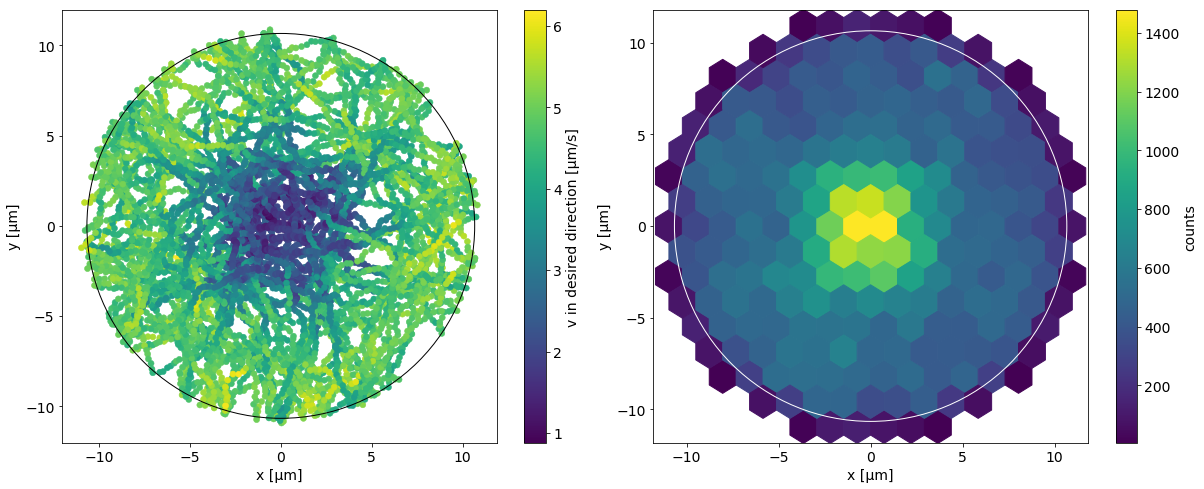

In [9]:
angle = particle[:shortlength,5]
particlesdisplay = np.zeros((shortlength,2))
particlesdisplay[:,0] = particle[:,0]*1e6
particlesdisplay[:,1] = particle[:,1]*1e6
directionvector = np.zeros((shortlength,2))
movingvector = np.zeros((shortlength,2))
velocity = np.zeros(shortlength);stepsize = np.zeros(shortlength)
velocitywithdiffusion=np.zeros(shortlength)
directionvector[:,0] = np.cos(angle[:]*np.pi/180)
directionvector[:,1] = np.sin(angle[:]*np.pi/180)
for i in range(1,shortlength-1):
    movingvector[i,0] = particlesdisplay[i,0]-particlesdisplay[i-1,0]
    movingvector[i,1] = particlesdisplay[i,1]-particlesdisplay[i-1,1]
    stepsize[i] = abs(np.dot(directionvector[i-1,:], movingvector[i,:]))
    velocity[i] = stepsize[i]/dt
velocitywithdiffusion[:] = np.sqrt(pow(movingvector[:,0],2)+pow(movingvector[:,1],2))/dt 
velocitywithdiffusion[0] = np.nan
velocity[0] = np.nan
meanvelocity = np.nanmean(velocity[:-1])
binwave=np.linspace(min(velocity[2:]),max(velocitywithdiffusion[2:]),20)
distancetocenter = np.sqrt(pow(particlesdisplay[:,0],2)+pow(particlesdisplay[:,1],2))
check = value2 * boundaryradius*1e6
#boundaryradius = pxtomum * 200
inside = 0
for i in range(1,shortlength):
    if distancetocenter[i] < check: inside += 1  

velodiff = np.zeros(shortlength)
for i in range(shortlength):
    xmove = noisesteps[i,0]
    ymove = noisesteps[i,1]
    velodiff[i] = np.sqrt(pow(xmove,2)+pow(ymove,2))*1e6

plotlength = min(10000,stepsexp)
smoothvalue = 10
smoothit = smooth(velocity[2:],smoothvalue)      
x = particlesdisplay[smoothvalue:plotlength-smoothvalue,0]
y = particlesdisplay[smoothvalue:plotlength-smoothvalue,1]
v = smoothit[smoothvalue:plotlength-smoothvalue]
gridsizevalue = 15
fig, axs = plt.subplots(ncols=2, figsize=(17,7))
fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
ax = axs[0]
circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='k', fill=False)
ax.add_artist(circle2)
im = ax.scatter(x,y,c=v,linewidths=0.5)
#ax.scatter(mean(x),mean(y),c='r',linewidths=15)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.tick_params(axis='y')
value = 1.1*boundaryradius*1e6
plt.xlim(-value, value)
plt.ylim(-value, value)
cb = fig.colorbar(im, ax=ax)
cb.set_label('v in desired direction [µm/s]')

x = particlesdisplay[:,0]
y = particlesdisplay[:,1]
factor = 1.08
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = axs[1]
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
plt.show()

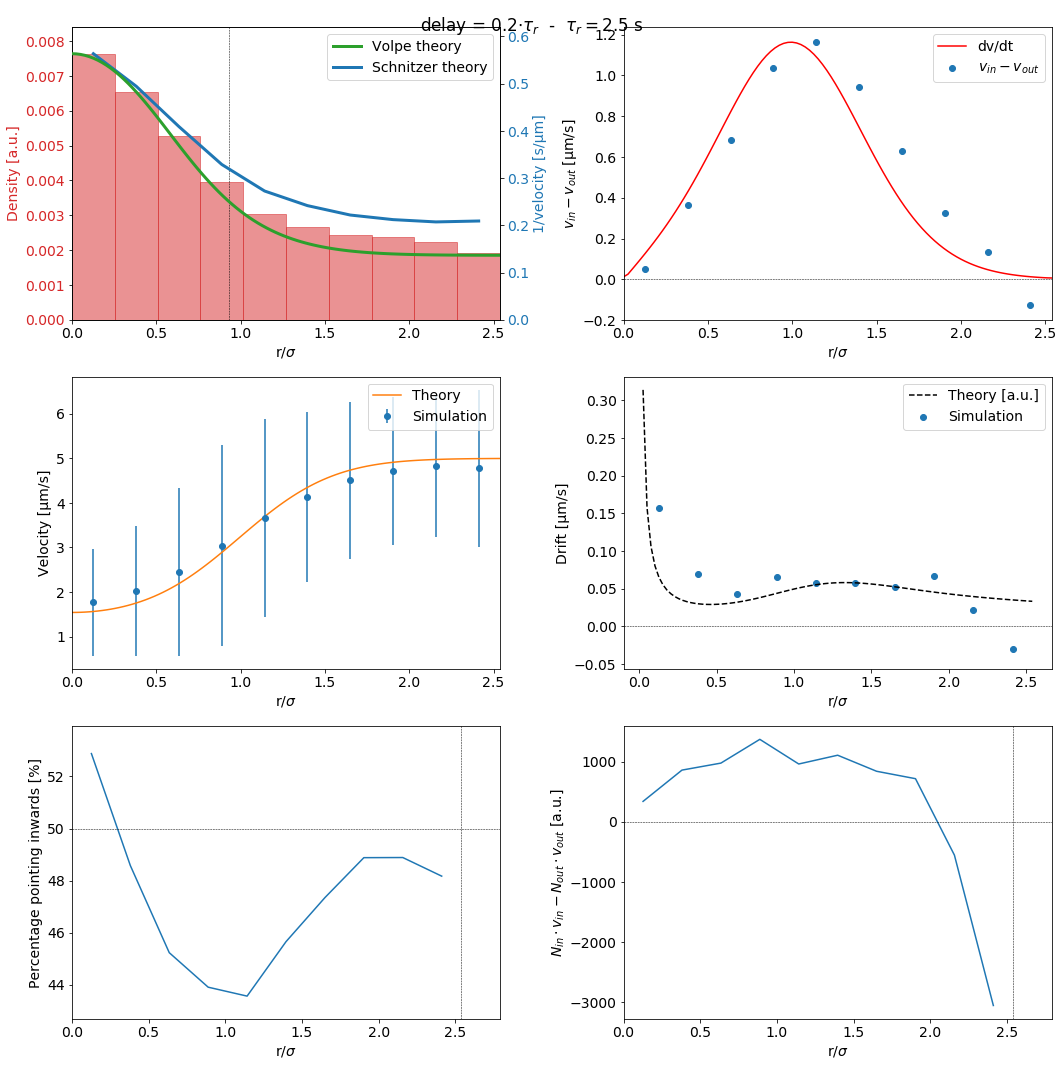

In [11]:
newangle = np.zeros(stepsexp); newangle = particle[:,5].copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,stepsexp):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]
    
check = True; i = 1
reorwave= np.zeros((stepsexp,2))
while check == True:
    diff = np.zeros(stepsexp-i)
    for j in range(i,stepsexp): diff[j-i] = abs(newangle[j] - newangle[j-i])  #Calculate the direction change for i steps
    mean = np.mean(diff[:stepsexp-i])   #Calculate the standard derivation
    reorwave[i,0] = i*dt
    reorwave[i,1] = mean
    if mean/57.3 >= 1: 
        check = False
        reorlen = i
    else: i += 1 
    if i == stepsexp:
        reorlen = i
        i = 666/dt
        check = False       
reorientationtime = i*dt 

radialdata = np.zeros((steps,15))  #0 - bins, 1 - counts, 2 - v, 3 - verr, 4 - v outwards, 5 - v outwards err
base=boundaryradius*1e6/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
for i in range(steps): radialdata[i,0] = i*base
averagebinposition = np.zeros(steps-1)
for i in range(1,steps): averagebinposition[i-1] = (radialdata[i,0]+radialdata[i-1,0])/2
area = np.zeros(steps-1)
for i in range(1,steps): area[i-1] = np.pi*(radialdata[i,0]**2-radialdata[i-1,0]**2)   

distancetocenter = np.sqrt(pow(particlesdisplay[:,0],2)+pow(particlesdisplay[:,1],2))
check = value2 * boundaryradius
inside = 0
for i in range(1,stepsexp):
    if distancetocenter[i] < check: inside += 1 
inside /= stepsexp

step = np.zeros(shortlength); shell = np.zeros(shortlength); inout = []
collectdrift = np.zeros((stepsexp,steps))
collectvelocity = np.zeros((stepsexp,steps,3))
count = np.zeros((steps,3))
for i in range(1,stepsexp):
    j = 0
    check = False
    while check == False:
        if distancetocenter[i] < radialdata[j,0] and distancetocenter[i] > radialdata[j-1,0]:
            check = True
            radialdata[j,1] += 1
            collectvelocity[int(count[j,0]),j,0] = velocity[i]
            count[j,0] += 1                        
            radialdrift = distancetocenter[i]-distancetocenter[i-driftdelay]
            collectdrift[int(count[j,0]),j] = radialdrift
            step[i] = i; shell[i] = round(averagebinposition[j-1],2)
            if radialdrift > 0:  #moving outwards
                collectvelocity[int(count[j,1]),j,1] = velocity[i]
                count[j,1] += 1
                inout.append('outwards')
            if radialdrift < 0:  #moving inwards
                collectvelocity[int(count[j,2]),j,2] = velocity[i]
                count[j,2] += 1
                inout.append('inwards')
        else: j += 1
        if j == steps: check = True
    if shell[i] == 0:
        step[i] = i; shell[i] = 888
        if radialdrift < 0: inout.append('inwards')
        else: inout.append('outwards')
    
for i in range(1,steps): 
    radialdata[i,2] = np.mean(collectvelocity[:int(count[i,0]),i,0])    #total velocity
    radialdata[i,3] = np.nanvar(collectvelocity[:int(count[i,0]),i,0])
    radialdata[i,4] = np.mean(collectvelocity[:int(count[i,1]),i,1])    #moving outwards
    radialdata[i,5] = np.nanvar(collectvelocity[:int(count[i,1]),i,1])
    radialdata[i,6] = np.mean(collectvelocity[:int(count[i,2]),i,2])    #moving inwards
    radialdata[i,7] = np.nanvar(collectvelocity[:int(count[i,2]),i,2])
    radialdata[i,8] = radialdata[i,1]/area[i-1]#averagebinposition[i-1]                   #density
    radialdata[i,11] = -np.mean(collectdrift[:int(count[i,0]),i])/dt
    radialdata[i,12] = np.nanvar(collectdrift[:int(count[i,0]),i])/dt
dr = radialdata[1,0]
#sumdensity = sum(radialdata[1:,8]*dr)
radialdata[1:,8] /= np.nansum(radialdata[1:,1])                                                
radialdata[1:,9] = radialdata[1:,6] - radialdata[1:,4]                  #velocity difference
radialdata[1:,10] = np.sqrt(radialdata[1:,7]**2 + radialdata[1:,5]**2)
radialdata[1:,13] = count[1:,2]*radialdata[1:,6] - count[1:,1]*radialdata[1:,4]
radialdata[1:,14] = count[1:,2]/(count[1:,1]+count[1:,2])*100

dd, v = calcvelocity(boundaryradius*1e6,sigma*1e6,vfactor,amplitude,vmin)
diffv = np.gradient(v)/(dd[1]-dd[0])
maxpos = np.argmax(diffv)
maxdist = dd[maxpos]
sigmawave = np.zeros(steps)
base=boundaryradius*1e6/maxdist/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
for i in range(steps): sigmawave[i] = i*base
averagesigmaposition = np.zeros(steps-1)
for i in range(1,steps): averagesigmaposition[i-1] = (sigmawave[i]+sigmawave[i-1])/2
ddnew = np.linspace(0,boundaryradius*1e6/maxdist,100)
#distanceplot3 = distanceplot2/maxdist
meandensity = sum(averagesigmaposition*radialdata[1:,8])/sum(radialdata[1:,8])

dr = dd[1]
fig=plt.figure(1, figsize = (15,15) )
ax1 = plt.subplot(3,2,1)
color = 'tab:red'
ax1.set_xlabel(r'r/$\sigma$')
ax1.set_ylabel('Density [a.u.]', color=color)
bars = ax1.bar(averagesigmaposition, radialdata[1:,8],base, color=color,alpha = 0.5, edgecolor = color,label='Simulation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0,1.1*max(radialdata[1:,8])])
ax1.set_xlim([0,boundaryradius*1e6/maxdist])
ax1.axvline(x=meandensity,linewidth=0.5, color = 'k',linestyle='--',label = 'mean value')
ax1.set_title(' ')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('1/velocity [s/µm]', color=color)  # we already handled the x-label with ax1
line2 = ax2.plot(averagesigmaposition,1/radialdata[1:,2], color=color, linewidth = 3,label='Schnitzer theory')
#line2 = ax2.plot(dd,1/v, color=color, linewidth = 3,label='Schnitzer theory')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,1.1*np.nanmax(1/radialdata[1:,2])])

axb = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
axb.set_ylabel('1/velocity [s/µm]', color=color)  # we already handled the x-label with ax1
theory = 1/(v**(1+delay*dt/reorientationtime))           
line1 = axb.plot(ddnew,theory, color=color, linewidth = 3,label = 'Volpe theory')
axb.axis('off')
axb.set_ylim([0,1.1*np.nanmax(theory)])
lns = line1+line2
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs)

ax3 = plt.subplot(3,2,2)
diffv = np.gradient(v)/(dd[1]-dd[0])
ax3.set_ylabel('$v_{in}-v_{out}$ [µm/s]')
ax3.set_xlabel(r'r/$\sigma$')
ax3.set_title(' ')
#ax3.errorbar(averagebinposition,radialdata[1:,9],yerr=radialdata[1:,10], fmt='o',label ='$v_{in} - v_{out}$')
ax3.scatter(averagesigmaposition,radialdata[1:,9],label ='$v_{in} - v_{out}$')
ax3.plot(ddnew,diffv*np.nanmax(abs(radialdata[1:,9]))/max(diffv),color='r',label = 'dv/dt')
ax3.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
ax3.set_xlim([0,boundaryradius*1e6/maxdist])
ax3.legend()

ax4 = plt.subplot(3,2,3)
ax4.errorbar(averagesigmaposition, radialdata[1:,2],yerr=radialdata[1:,3], fmt='o',label='Simulation')
ax4.plot(ddnew,v*maxvelocity*1e6,label='Theory')
ax4.set_xlabel(r'r/$\sigma$')
ax4.set_ylabel('Velocity [µm/s]')
ax4.set_xlim([0,boundaryradius*1e6/maxdist])
ax4.legend()

ax5 = plt.subplot(3,2,4)
#plt.errorbar(averagebinposition,radialdata[1:,11],yerr=radialdata[1:,12], fmt='o',label='Simulation')
plt.scatter(averagesigmaposition,radialdata[1:,11],label='Simulation')
ax5.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
drifttheory = calcdrifttheory(v,dd,reorientationtime,delay*dt,dr)
plt.plot(ddnew,drifttheory/drifttheory[2]*radialdata[1,11],'k--',label='Theory [a.u.]')
#drifttheory = calcdrifttheory(radialdata[1:,2],averagebinposition,reorientationtime,delay*dt,base)
#plt.plot(averagebinposition,drifttheory*max(radialdata[1:,11]/max(drifttheory)),'k--',label='Theory [a.u.]')
ax5.set_xlabel(r'r/$\sigma$')
ax5.set_ylabel('Drift [µm/s]')
ax5.legend()

percentage2 = count[:,2]/(count[:,1]+count[:,2])*100
ax6 = plt.subplot(3,2,5)
plt.plot(averagesigmaposition,radialdata[1:,14])
plt.xlabel(r'r/$\sigma$')
plt.ylabel('Percentage pointing inwards [%]')
plt.axvline(x=boundaryradius*1e6/maxdist,linewidth=0.5, color = 'k',linestyle='--')
plt.axhline(y=50,linewidth=0.5, color = 'k',linestyle='--')
plt.ylim([0.98*min(radialdata[1:,14]),1.02*max(radialdata[1:,14])])
plt.xlim([0,1.1*boundaryradius*1e6/maxdist])
        
ax7 = plt.subplot(3,2,6)
plt.plot(averagesigmaposition,radialdata[1:,13])
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel(r'r/$\sigma$')
plt.ylabel(r'$N_{in} \cdot v_{in} - N_{out} \cdot v_{out}$ [a.u.]')
plt.xlim([0,1.1*boundaryradius*1e6/maxdist])
plt.axvline(x=boundaryradius*1e6/maxdist,linewidth=0.5, color = 'k',linestyle='--')

plt.suptitle('delay = '+str(round(delay*dt/reorientationtime,2))+r'$\cdot \tau_{r}$  -  $\tau_{r} = $'+str(round(reorientationtime,1))+' s')
plt.tight_layout() 
plt.savefig('Density layout'+str(delay)+'.pdf', format='pdf')
plt.show()

savefolder = '.'
string_temp = savefolder + '/DataImportant/'                         
if not os.path.exists(string_temp): os.makedirs(string_temp)
np.savetxt(string_temp + 'DataImportant'+str(delay)+'.txt', np.transpose([np.mean(distancetocenter),len(endpoint),inside,delay,reorientationtime,meandensity]),fmt='%1.6f')
string_temp = savefolder + '/DataRadial/'
if not os.path.exists(string_temp): os.makedirs(string_temp)           #0 - xpos             1 - mean v       2 - std v        3 - mean v_out   4 - std v_out    5 - mean v_in    6 - std v_in     7 - density      8 - v diff       9 - v diff std    10 - Drift        11 - std Drift    12 - % inwards  13 - N*v_in - N * v_out
np.savetxt(string_temp + 'DataRadial'+str(delay)+'.txt', np.transpose([averagesigmaposition,radialdata[1:,2],radialdata[1:,3],radialdata[1:,4],radialdata[1:,5],radialdata[1:,6],radialdata[1:,7],radialdata[1:,8],radialdata[1:,9],radialdata[1:,10],radialdata[1:,11],radialdata[1:,12],radialdata[1:,14],radialdata[1:,13]]),fmt='%1.6f')                         
string_temp = savefolder + '/DataGeneral/'
if not os.path.exists(string_temp): os.makedirs(string_temp)           #0  1              2     3    4    5         6    7    8  9    10    
np.savetxt(string_temp + 'DataGeneral'+str(delay)+'.txt', np.transpose([dt,boundaryradius,delay,vmin,vmax,fitlength,sigma,D_0]),fmt='%1.6f')

50642


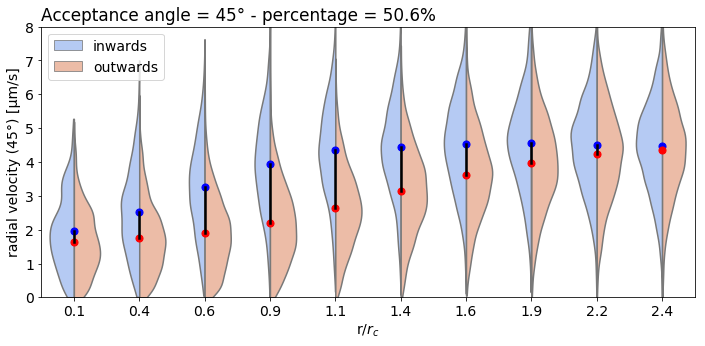

In [13]:
    driftdelay = 1    
    dd, v = calcvelocity(boundaryradius*1e6,sigma*1e6,vfactor,amplitude,vmin)
    diffv = np.gradient(v)/(dd[1]-dd[0])
    maxpos = np.argmax(diffv)
    maxdist = dd[maxpos]
    radialdistance = distancetocenter
    
    radialdist = np.zeros((steps,3))       #0 - radius, 1 - effective radial drift, 2 - counts
    base=boundaryradius*1e6/(steps-1)  #4 - v inwards, 5 - v outwards
    for i in range(steps): radialdist[i,0] = i*base
    for i in range(1, steps):
        radialdist[i,1] = round((radialdist[i,0]+radialdist[i-1,0])/2,1)
        radialdist[i,2] = round(radialdist[i,1]/maxdist,1)
      
    angletocenter = np.zeros(shortlength)
    for i in range(shortlength):
        a = [-np.cos((angle[i]+180)*np.pi/180),-np.sin((angle[i]+180)*np.pi/180)]
        b = [particlesdisplay[i,0],particlesdisplay[i,1]]
        angletocenter[i] = np.arccos(np.dot(a,b)/(vectorlength(a)*vectorlength(b)))*180/np.pi
     
    radialdrift = np.zeros(shortlength)
    radialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                         #3 - counts outwards, 4 - drift inwards  
    limitedradialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                         #3 - counts outwards, 4 - drift inwards
    radialstats[:,0] = limitedradialstats[:,0] = radialdist[:,1]     
    allradialdata = np.zeros((shortlength,5))      #0 - not used, 1 - shell, 2 - in or out, 3 - radial drift
                                                 #4 - angletocenter
    limitedradialdata = np.zeros((shortlength,5))  #0 - step, 1 - shell, 2 - in or out, 3 - radial drift
    
    checkangle = 45
    count = 0
    inouttest = []; limitedinout = []  
    point = max(driftdelay,2)
    for i in range(point,shortlength):
        for j in range(1,steps):
            if radialdistance[i] < radialdist[j,0] and radialdistance[i] > radialdist[j-1,0]:
                radialdrift[i] = (radialdistance[i]-radialdistance[i-driftdelay])/dt
                allradialdata[i,1] = radialdist[j,2]
                allradialdata[i,3] = abs(radialdrift[i])
                allradialdata[i,4] = angletocenter[i]
                if radialdrift[i] <= 0:
                    radialstats[j,1] += 1
                    radialstats[j,2] += abs(radialdrift[i])
                    inouttest.append('inwards')
                    allradialdata[i,2] = 0
                    if angletocenter[i] < checkangle:
                        limitedradialstats[j,1] += 1
                        limitedradialstats[j,2] += abs(radialdrift[i])
                        limitedradialdata[count,0] = i
                        limitedradialdata[count,1] = radialdist[j,2]
                        limitedradialdata[count,2] = 0
                        limitedradialdata[count,3] = abs(radialdrift[i])
                        limitedradialdata[i,4] = angletocenter[i]
                        limitedinout.append('inwards')
                        count += 1
                else:
                    radialstats[j,3] += 1
                    radialstats[j,4] += radialdrift[i]
                    allradialdata[i,2] = 1
                    inouttest.append('outwards')
                    if angletocenter[i] > 180 - checkangle:
                        limitedradialstats[j,3] += 1
                        limitedradialstats[j,4] += abs(radialdrift[i])
                        limitedradialdata[count,0] = i
                        limitedradialdata[count,1] = radialdist[j,2]
                        limitedradialdata[count,2] = 1
                        limitedradialdata[count,3] = abs(radialdrift[i])
                        limitedradialdata[i,4] = angletocenter[i]
                        limitedinout.append('outwards')
                        count += 1
                j=steps
        if allradialdata[i,1] == 0: allradialdata[i,2] = 888
    radialstats[:,2] /= radialstats[:,1]
    radialstats[:,4] /= radialstats[:,3]
    limitedradialstats[:,2] /= limitedradialstats[:,1]
    limitedradialstats[:,4] /= limitedradialstats[:,3]
    print(count)
    
    vin = np.zeros(steps);vout = np.zeros(steps); limitedvin = np.zeros(steps); limitedvout = np.zeros(steps)
    for i in range(1,steps):
        vin[i] = round(radialstats[i,2],2)
        vout[i] = round(radialstats[i,4],2)
        limitedvin[i] = round(limitedradialstats[i,2],2)
        limitedvout[i] = round(limitedradialstats[i,4],2)
        
    alldata1 = list(zip(arange(point,shortlength),allradialdata[point:,1],inouttest[point:],allradialdata[point:,3]))
    alldata2 = pd.DataFrame(data = alldata1, columns=['step', 'distance', 'direction', 'velocity'])
    alldata3 = alldata2.replace(888, 'outside')
    limitedalldata1 = list(zip(arange(point,count),limitedradialdata[point:count,1],limitedinout[point:count],limitedradialdata[point:count,3]))
    limitedalldata2 = pd.DataFrame(data = limitedalldata1, columns=['step', 'distance', 'direction', 'velocity'])
    limitedalldata3 = limitedalldata2.replace(888, 'outside')
    
    fig=plt.figure(1, figsize = (10,5) )
    ax4 = plt.subplot(1,1,1)
    ax4 = sns.violinplot(x="distance", y="velocity", hue="direction", hue_order = ['inwards','outwards'], order = radialdist[1:,2],
                            data=limitedalldata3, palette="coolwarm", split=True, scale="count", cut=0, inner=None)#,bw=.2, scale_hue=False
    ax4.set_ylabel('radial velocity ('+str(checkangle)+'°) [µm/s]')
    ax4.set_xlabel('r/$r_{c}$')
    numwave=np.linspace(0,len(vin[1:]),len(limitedvin[1:]),endpoint=False)
    for i in range(1,len(vin[1:])):
        ax4.plot([numwave[i-1],numwave[i-1]],[limitedvin[i],limitedvout[i]],color='k',linewidth=2.5)
    ax4.scatter(numwave,limitedvin[1:],s=50,c='b')#,label = 'v in')
    ax4.scatter(numwave,limitedvout[1:],s=50,c='r')#,label = 'v out')
    ax4.set_ylim([0,8])
    ax4.set_title('Acceptance angle = '+str(checkangle)+'° - percentage = '+str(round(count/shortlength*100,1))+'%',loc='left')
    plt.legend(loc='upper left')
    plt.tight_layout() 
    plt.show()